In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

## California Housing Dataset Features

The dataset contains the following features for each district in California:

- **MedInc**: Median income in block group
- **HouseAge**: Median house age in block group
- **AveRooms**: Average number of rooms per household
- **AveBedrms**: Average number of bedrooms per household
- **Population**: Block group population
- **AveOccup**: Average number of household members
- **Latitude**: Block group latitude
- **Longitude**: Block group longitude

The target variable is **MedHouseVal**: Median house value for California districts (in $100,000s).

In [108]:
dataset = fetch_california_housing()
feature_names = dataset.feature_names
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df["MedHouseValue"] = dataset.target

print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseValue  
0    -122.23          4.526  
1    -122.22          3.585  
2    -122.24          3.521  
3    -122.25          3.413  
4    -122.25          3.422  


In [109]:
print(df.shape)
print(df.describe())

(20640, 9)
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  MedHouseValue  
count  20640.000000  20640.000000  20640.000000   20640.000000  
mean       3.070655     35.631861   -119.569704       2.068558  
std       10.386050      2.135952      2.003532       1.153956  
min        0.6923

In [110]:
# Apply reasonable filters
df = df[
    (df['AveRooms'] <= 10) &
    (df['AveBedrms'] <= 5) &
    (df['AveOccup'] <= 10)
]

Add 2 engineered features

In [111]:
# df['RoomsPerBedroom'] = df['AveRooms'] / df['AveBedrms']
# df['PeoplePerRoom'] = df['AveOccup'] / df['AveRooms']

In [112]:
y = df['MedHouseValue']
X = df.drop(columns=['MedHouseValue'])  # , 'AveBedrms', 'Population', 'HouseAge'

X.shape, y.shape

((20379, 8), (20379,))

In [113]:
# Train/Test Split (80/20) with shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Generate timestamp for filenames
timestamp = datetime.now().strftime("%m-%d_%H-%M")

In [114]:
model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

param_dist = {
    'n_estimators': [200, 300, 500],
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.4, 0.6, 0.8, 1.0]
}

In [115]:
EXPERIMENT_NAME = "California Housing - XGBoost Tuning"
MODEL_NAME = "california-housing"

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Run ID: c2d4b7382aef400d90484db4c448f5d8


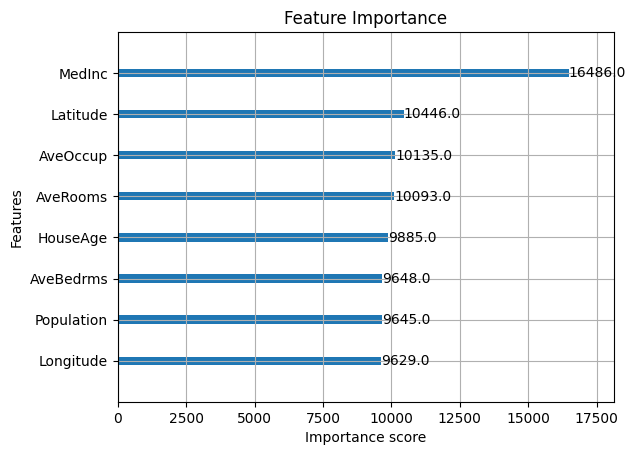

In [116]:
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,               # Try 30 combinations
    scoring='neg_mean_squared_error',
    cv=5,                    # 5-fold cross-validation
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Kill any active run
try:
    mlflow.end_run()
except Exception as e:
    print("No active run to end.")

# Start MLFlow run
mlflow.set_experiment(EXPERIMENT_NAME)
input_example = X_train.head(5)  # Take first 5 rows as example input

with mlflow.start_run() as run:
    search.fit(X_train, y_train)
    
    best_params = search.best_params_
    
    # Retrain best model on full training set
    best_model = search.best_estimator_.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Log metrics and model
    mlflow.log_params(best_params)
    mlflow.log_metrics({"rmse": rmse, "mae": mae})
    mlflow.xgboost.log_model(best_model, "model", input_example=input_example)

    # Feature Importance Plot
    xgb.plot_importance(best_model)
    plt.title("Feature Importance")
    feature_imp_filename = f"runs/feature_importance_{timestamp}.png"
    plt.savefig(feature_imp_filename)
    mlflow.log_artifact(feature_imp_filename, "plots")

    run_id = run.info.run_id
    print("Run ID:", run_id)

In [117]:
print("Best Parameters:", best_params)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Best Parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.05}
Test RMSE: 0.4468
Test MAE: 0.2867


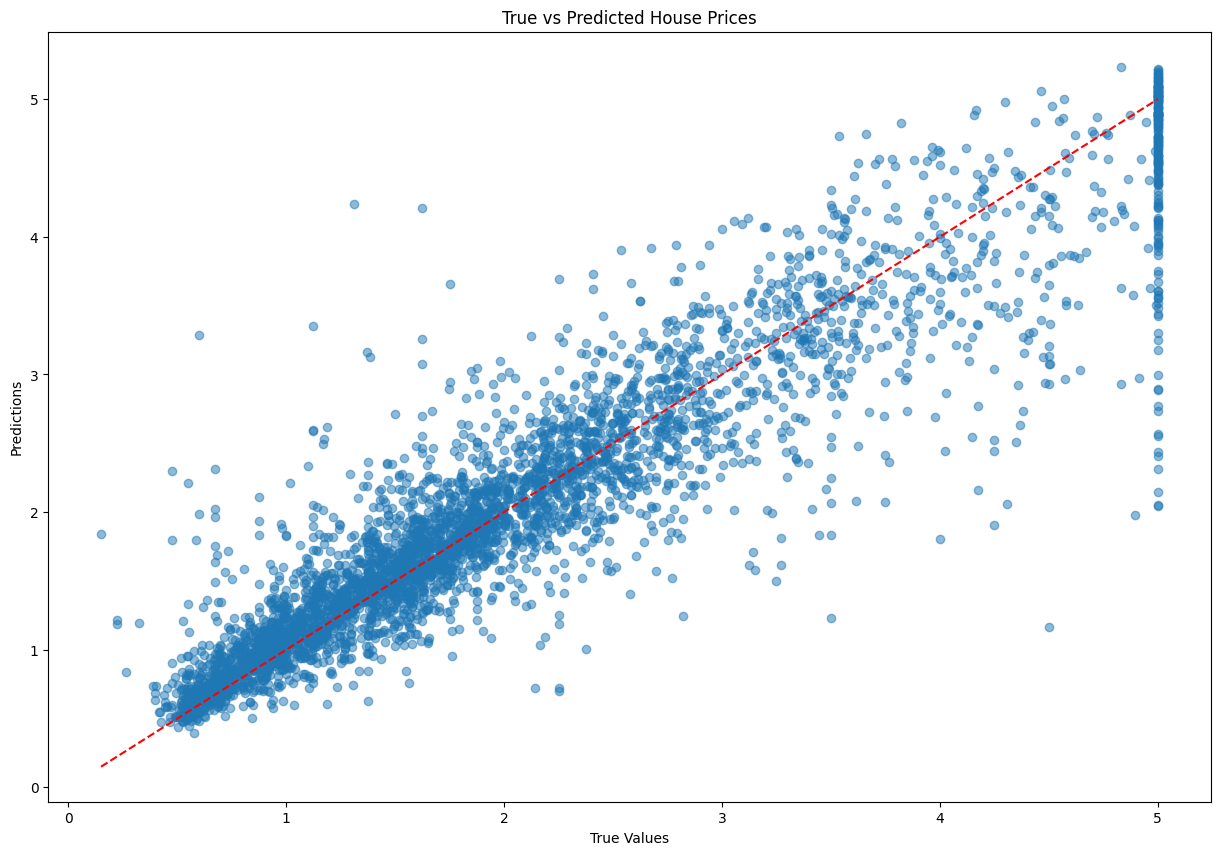

In [118]:
plt.figure(figsize=(15, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted House Prices")
true_vs_pred_filename = f"runs/true_vs_pred_{timestamp}.png"
plt.savefig(true_vs_pred_filename)
mlflow.log_artifact(true_vs_pred_filename, "plots")
plt.show()

In [ ]:
# Get the latest run ID from the experiment
client = MlflowClient()
experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
runs = client.search_runs(experiment_ids=[experiment_id], max_results=2)

# Find the latest "Finished" run with the model logged
for run in runs:
    if "model" in run.data.tags.get("mlflow.log-model.history", ""):
        run_id = run.info.run_id
        break
print("Latest Run ID:", run_id)
# Build model URI
model_uri = f"runs:/{run_id}/model"

# Register model
registered_model = mlflow.register_model(model_uri, MODEL_NAME)

Latest Run ID: c2d4b7382aef400d90484db4c448f5d8
Model 'california-housing' registered with version 5


Registered model 'california-housing' already exists. Creating a new version of this model...
Created version '5' of model 'california-housing'.


In [ ]:
import os

version = registered_model.version
LOCAL_MODEL_PATH = "."

model_version_info = client.get_model_version(MODEL_NAME, version)

# This downloads all model files (model, ) under the versioned model to the local path
mlflow.artifacts.download_artifacts(
    artifact_uri=model_version_info.source,
    dst_path=LOCAL_MODEL_PATH
)

print(f"Model saved to: {os.path.abspath(LOCAL_MODEL_PATH)}")

Model saved to: c:\TuanTA\ML Projects\MLOps-Projects\MLFlow


In [139]:
s3_bucket = "s3://s3-ttran-models/mlflow/models/california-housing"
os.system(f"aws s3 cp \"{os.path.abspath(LOCAL_MODEL_PATH)}\model\" {s3_bucket}/{version} --recursive")

0